In [79]:
!pip install -r requirements.txt

In [80]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import spacy
import re,string,unicodedata
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from textblob import TextBlob
from textblob import Word
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix, roc_auc_score, roc_curve, f1_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### 1. Data Preperation

In [81]:
dataset_path = '/content/IMDB Dataset.csv'
review_data = pd.read_csv(dataset_path)
print(review_data.shape)
review_data.head(10)

(50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [82]:
review_data.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [83]:
def clean_text(text, remove_digits=True):
    text = BeautifulSoup(text, "html.parser").get_text()
    text = re.sub(r'\[[^]]*\]', '', text)

    if remove_digits:
        pattern = r'[^a-zA-Z\s]'
    else:
        pattern = r'[^a-zA-Z0-9\s]'
    text = re.sub(pattern, '', text)

    return text

def text_stemmer(text):
    ps=nltk.porter.PorterStemmer()
    text= ' '.join([ps.stem(word) for word in text.split()])
    return text

In [84]:
def remove_stopwords(text, is_lower_case=False):
    stop = set(stopwords.words('english'))
    tokens = word_tokenize(text)
    tokens = [token.strip() for token in tokens]

    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stop]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stop]

    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

In [85]:
review_data['review']=review_data['review'].apply(clean_text)
review_data['review']=review_data['review'].apply(text_stemmer)
review_data['review']=review_data['review'].apply(remove_stopwords)

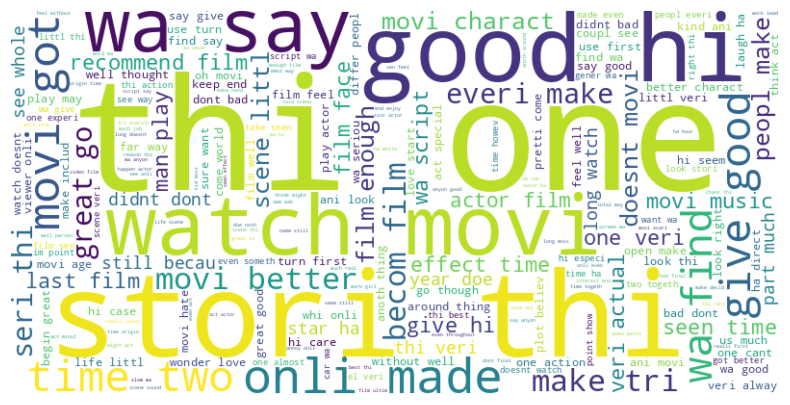

In [86]:
wordcloud = WordCloud(width = 800, height = 400, background_color ='white').generate(combined_unique_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

plt.savefig('wordcloud.png', format='png', dpi=300)  # Ensures the image is saved with high resolution

plt.show()

In [87]:
reviews = review_data['review']
sentiments = review_data['sentiment']

norm_train_reviews, norm_test_reviews, train_sentiments, test_sentiments = train_test_split(
    reviews, sentiments, test_size=0.2, random_state=42, shuffle=True)

lb = LabelBinarizer()


train_sentiments = lb.fit_transform(train_sentiments)

test_sentiments = lb.transform(test_sentiments)

print("Train Sentiments Shape:", train_sentiments.shape)
print("Test Sentiments Shape:", test_sentiments.shape)

Train Sentiments Shape: (40000, 1)
Test Sentiments Shape: (10000, 1)


## 2. Data transformation

In [88]:
cv=CountVectorizer(min_df=0,max_df=1,binary=False,ngram_range=(1,3))
cv_train_reviews=cv.fit_transform(norm_train_reviews)
cv_test_reviews=cv.transform(norm_test_reviews)

print('BOW_cv_train:',cv_train_reviews.shape)
print('BOW_cv_test:',cv_test_reviews.shape)

BOW_cv_train: (40000, 6127378)
BOW_cv_test: (10000, 6127378)


In [89]:
tv=TfidfVectorizer(min_df=0,max_df=1,use_idf=True,ngram_range=(1,3))
tv_train_reviews=tv.fit_transform(norm_train_reviews)
tv_test_reviews=tv.transform(norm_test_reviews)

print('Tfidf_train:',tv_train_reviews.shape)
print('Tfidf_test:',tv_test_reviews.shape)

Tfidf_train: (40000, 6127378)
Tfidf_test: (10000, 6127378)


In [90]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [92]:
path_to_save = '/content/drive/My Drive/sent/bow_vectorizer.pkl'
with open(path_to_save, 'wb') as f:
    pickle.dump(cv, f)
path_to_save = '/content/drive/My Drive/sent/tfidf_vectorizer.pkl'
with open(path_to_save, 'wb') as f:
    pickle.dump(tv, f)

## 3. Model Training

In [93]:
def evaluate_model(model_name, transformation_type, features_train, labels_train, features_test, labels_test, export_path=None):
    if model_name == 'logistic_regression':
        model = LogisticRegression(penalty='l2', max_iter=500, C=1, random_state=42)
    elif model_name == 'svm':
        model = SGDClassifier(loss='hinge', max_iter=500, random_state=42)
    elif model_name == 'multinomial_nb':
        model = MultinomialNB()
    else:
        raise ValueError("Unsupported model type")

    model.fit(features_train, labels_train)

    test_predictions = model.predict(features_test)

    precision = precision_score(labels_test, test_predictions, zero_division=0)
    recall = recall_score(labels_test, test_predictions)
    f1 = f1_score(labels_test, test_predictions)
    accuracy = accuracy_score(labels_test, test_predictions)
    cm = confusion_matrix(labels_test, test_predictions)

    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)

    roc_auc = "ROC AUC not applicable"
    labels_test = labels_test.ravel()
    if len(set(labels_test)) == 2:
        try:
            probs = model.predict_proba(features_test)[:, 1]
            roc_auc = roc_auc_score(labels_test, probs)
        except AttributeError:  # Some models like SVM do not support predict_proba
            roc_auc = "ROC AUC not applicable"
    else:
        roc_auc = "ROC AUC not applicable for non-binary classification"

    metrics = {
        'Model Name': model_name,
        'Transformation Type': transformation_type,
        'Precision': precision,
        'Recall': recall,
        'Accuracy': accuracy,
        'Specificity': specificity,
        'F1 Score': f1,
        'Confusion Matrix': cm,
        'ROC AUC': roc_auc
    }

    if export_path:
        with open(f'/content/drive/My Drive/sent/{export_path}', 'wb') as file:
            pickle.dump(model, file)

    return metrics

In [94]:
metrics_bow_lr = evaluate_model(
    'logistic_regression', 'bag_of_words',
    cv_train_reviews, train_sentiments,
    cv_test_reviews, test_sentiments,
    export_path='logistic_regression_model_bow.pkl'
)

# Evaluate and export SVM with Bag of Words features
metrics_bow_svm = evaluate_model(
    'svm', 'bag_of_words',
    cv_train_reviews, train_sentiments,
    cv_test_reviews, test_sentiments,
    export_path='svm_model_bow.pkl'
)

# Evaluate and export Multinomial Naive Bayes with Bag of Words features
metrics_bow_mnb = evaluate_model(
    'multinomial_nb', 'bag_of_words',
    cv_train_reviews, train_sentiments,
    cv_test_reviews, test_sentiments,
    export_path='multinomial_nb_model_bow.pkl'
)

# Evaluate and export Logistic Regression with TF-IDF features
metrics_tfidf_lr = evaluate_model(
    'logistic_regression', 'tfidf',
    tv_train_reviews, train_sentiments,
    tv_test_reviews, test_sentiments,
    export_path='logistic_regression_model_tfidf.pkl'
)

# Evaluate and export SVM with TF-IDF features
metrics_tfidf_svm = evaluate_model(
    'svm', 'tfidf',
    tv_train_reviews, train_sentiments,
    tv_test_reviews, test_sentiments,
    export_path='svm_model_tfidf.pkl'
)

# Evaluate and export Multinomial Naive Bayes with TF-IDF features
metrics_tfidf_mnb = evaluate_model(
    'multinomial_nb', 'tfidf',
    tv_train_reviews, train_sentiments,
    tv_test_reviews, test_sentiments,
    export_path='multinomial_nb_model_tfidf.pkl'
)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

In [97]:
results = []
results.append(metrics_bow_lr)
results.append(metrics_bow_svm)
results.append(metrics_bow_mnb)
results.append(metrics_tfidf_lr)
results.append(metrics_tfidf_svm)
results.append(metrics_tfidf_mnb)
metrics_df = pd.DataFrame(results)

In [96]:
metrics_df.to_csv('results.csv')